# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA

from scipy.signal import savgol_filter

from mpl_toolkits import mplot3d

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/02_visualization'

# Loading data

## UV/Vis spectra (scaled & smoothed)

In [4]:
path_to_uv_vis = './../data/preprocessed_data/uv_vis_scaled.csv'

In [5]:
data = pd.read_csv(path_to_uv_vis, sep=',', index_col=0)

print(data.shape)
data.head(3)

(26, 1421)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
wavelength,900.000000,899.500000,899.000000,898.500000,8.980000e+02,897.500000,897.000000,896.500000,896.000000,895.500000,895.000000,894.500000,894.000000,893.500000,893.000000,892.500000,892.000000,891.500000,891.000000,890.500000,890.000000,889.500000,889.000000,888.500000,888.000000,...,202.000000,201.500000,201.000000,200.50000,200.000000,199.500000,199.000000,198.500000,198.000000,197.500000,197.000000,196.500000,196.000000,195.500000,195.000000,194.500000,194.000000,193.500000,193.000000,192.50000,192.000000,191.500000,191.000000,190.500000,190.000000
1,0.000028,0.000017,0.000009,0.000003,4.766199e-07,0.000000,0.000002,0.000006,0.000013,0.000021,0.000032,0.000044,0.000058,0.000074,0.000092,0.000111,0.000131,0.000153,0.000176,0.000200,0.000225,0.000251,0.000278,0.000306,0.000334,...,0.908611,0.906940,0.905411,0.90403,0.902806,0.901747,0.900858,0.900149,0.899625,0.899296,0.899168,0.899248,0.899545,0.900065,0.900816,0.901806,0.903042,0.904531,0.906281,0.90830,0.910594,0.913171,0.916039,0.919206,0.922678
2,0.000000,0.000337,0.000658,0.000963,1.252841e-03,0.001527,0.001787,0.002034,0.002266,0.002486,0.002694,0.002889,0.003073,0.003247,0.003410,0.003563,0.003707,0.003842,0.003969,0.004088,0.004200,0.004306,0.004405,0.004498,0.004586,...,0.977502,0.978137,0.978782,0.97944,0.980112,0.980801,0.981509,0.982239,0.982991,0.983769,0.984575,0.985411,0.986280,0.987182,0.988121,0.989099,0.990117,0.991179,0.992286,0.99344,0.994644,0.995900,0.997210,0.998576,1.000000


## Samples description

In [6]:
path_to_samples_description = './../../ftir/qualitative_analysis/data/preprocessed_data/ftir_description.csv'

In [7]:
samples_description = pd.read_csv(path_to_samples_description, sep=',', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


*Selecting only `Train` part of samples description*

In [8]:
samples_description = (
    samples_description
    .loc[samples_description['Label'] == 'Train']
    .drop(columns=['Label'])
)

print(samples_description.shape)
samples_description.head(3)

(25, 3)


,Description,Type,Class
1,"MFGO, разб. 1:20",$GO$,1
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1


# Data visualization & analysis

## Dataset wrangling

In [9]:
type_dict = {
    '$rGO$': '$вОГ$',
    '$GO$': '$ОГ$',
    '$GO_{d}$': '$ОГ_{диализ}$',
}

samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

print(samples_description.shape)
samples_description.head(3)

(25, 3)


,Description,Type,Class
1,"MFGO, разб. 1:20",$ОГ$,1
2,"HGO, 0.0116 г в 25 мл H2O",$ОГ$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$ОГ$,1


*`log-log` data calculation*

In [10]:
data_log = data.copy()

data_log = np.log(data_log)

print(data_log.shape)
data_log.head(3)

(26, 1421)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
wavelength,6.802395,6.801839,6.801283,6.800727,6.800170,6.799613,6.799056,6.798498,6.797940,6.797382,6.796824,6.796265,6.795706,6.795146,6.794587,6.794027,6.793466,6.792905,6.792344,6.791783,6.791221,6.790660,6.790097,6.789535,6.788972,...,5.308268,5.305789,5.303305,5.300814,5.298317,5.295814,5.293305,5.290789,5.288267,5.285739,5.283204,5.280662,5.278115,5.275560,5.273000,5.270432,5.267858,5.265278,5.262690,5.260096,5.257495,5.254888,5.252273,5.249652,5.247024e+00
1,-10.475848,-10.970103,-11.620067,-12.580336,-14.556547,-inf,-13.167253,-12.004549,-11.288547,-10.770386,-10.365173,-10.033285,-9.752938,-9.510850,-9.298319,-9.109332,-8.939559,-8.785779,-8.645534,-8.516900,-8.398350,-8.288650,-8.186786,-8.091921,-8.003351,...,-0.095838,-0.097679,-0.099367,-0.100892,-0.102247,-0.103422,-0.104407,-0.105195,-0.105777,-0.106143,-0.106286,-0.106196,-0.105866,-0.105288,-0.104454,-0.103356,-0.101986,-0.100338,-0.098405,-0.096181,-0.093658,-0.090832,-0.087696,-0.084245,-8.047548e-02
2,-inf,-7.994078,-7.325693,-6.945083,-6.682342,-6.484214,-6.326974,-6.197958,-6.089602,-5.997023,-5.916880,-5.846786,-5.784972,-5.730089,-5.681085,-5.637119,-5.597508,-5.561687,-5.529185,-5.499598,-5.472580,-5.447832,-5.425088,-5.404111,-5.384692,...,-0.022755,-0.022105,-0.021446,-0.020774,-0.020088,-0.019386,-0.018664,-0.017921,-0.017155,-0.016364,-0.015545,-0.014696,-0.013815,-0.012901,-0.011950,-0.010961,-0.009932,-0.008860,-0.007744,-0.006582,-0.005370,-0.004109,-0.002794,-0.001425,-2.220446e-16


*`log-log` wavelength range selection*

In [11]:
data_log_selected = data_log.copy()

data_log_selected = data_log_selected.loc[:, (data_log_selected.loc['wavelength'] > np.log(299.5)) & (data_log_selected.loc['wavelength'] < np.log(500.5))]

print(data_log_selected.shape)
data_log_selected.head(3)

(26, 401)


,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,...,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201
wavelength,6.214608,6.213608,6.212606,6.211604,6.210600,6.209596,6.208590,6.207583,6.206576,6.205567,6.204558,6.203547,6.202536,6.201523,6.200509,6.199494,6.198479,6.197462,6.196444,6.195425,6.194405,6.193384,6.192362,6.191339,6.190315,...,5.743003,5.741399,5.739793,5.738184,5.736572,5.734958,5.733341,5.731722,5.730100,5.728475,5.726848,5.725218,5.723585,5.721950,5.720312,5.718671,5.717028,5.715382,5.713733,5.712081,5.710427,5.708770,5.707110,5.705448,5.703782
1,-2.566615,-2.562963,-2.559266,-2.555579,-2.551870,-2.548174,-2.544482,-2.540794,-2.537134,-2.533390,-2.529736,-2.526064,-2.522403,-2.518707,-2.515025,-2.511316,-2.507620,-2.503926,-2.500237,-2.496555,-2.492885,-2.489224,-2.485522,-2.481851,-2.478160,...,-0.991362,-0.986670,-0.981998,-0.977335,-0.972677,-0.968032,-0.963403,-0.958789,-0.954199,-0.949623,-0.945074,-0.940557,-0.936055,-0.931587,-0.927125,-0.922693,-0.918296,-0.913918,-0.909582,-0.905266,-0.900972,-0.896721,-0.892487,-0.888292,-0.884125
2,-2.084391,-2.081853,-2.079219,-2.076553,-2.074005,-2.071341,-2.068676,-2.066181,-2.063509,-2.060884,-2.058138,-2.055618,-2.052974,-2.050221,-2.047502,-2.044553,-2.041661,-2.038682,-2.035821,-2.032832,-2.030010,-2.027045,-2.024323,-2.021658,-2.018951,...,-0.836921,-0.833055,-0.829276,-0.825468,-0.821635,-0.817810,-0.813972,-0.810072,-0.806209,-0.802378,-0.798580,-0.794839,-0.791098,-0.787440,-0.783750,-0.780026,-0.776327,-0.772652,-0.768980,-0.765373,-0.761729,-0.758101,-0.754536,-0.750967,-0.747434


## Principal spectra of 3 *GO* types

In [12]:
wavelength = data.loc['wavelength']

go_spectrum = data.loc['9']
rgo_spectrum = data.loc['10']
god_spectrum = data.loc['23']

fontsize = 14

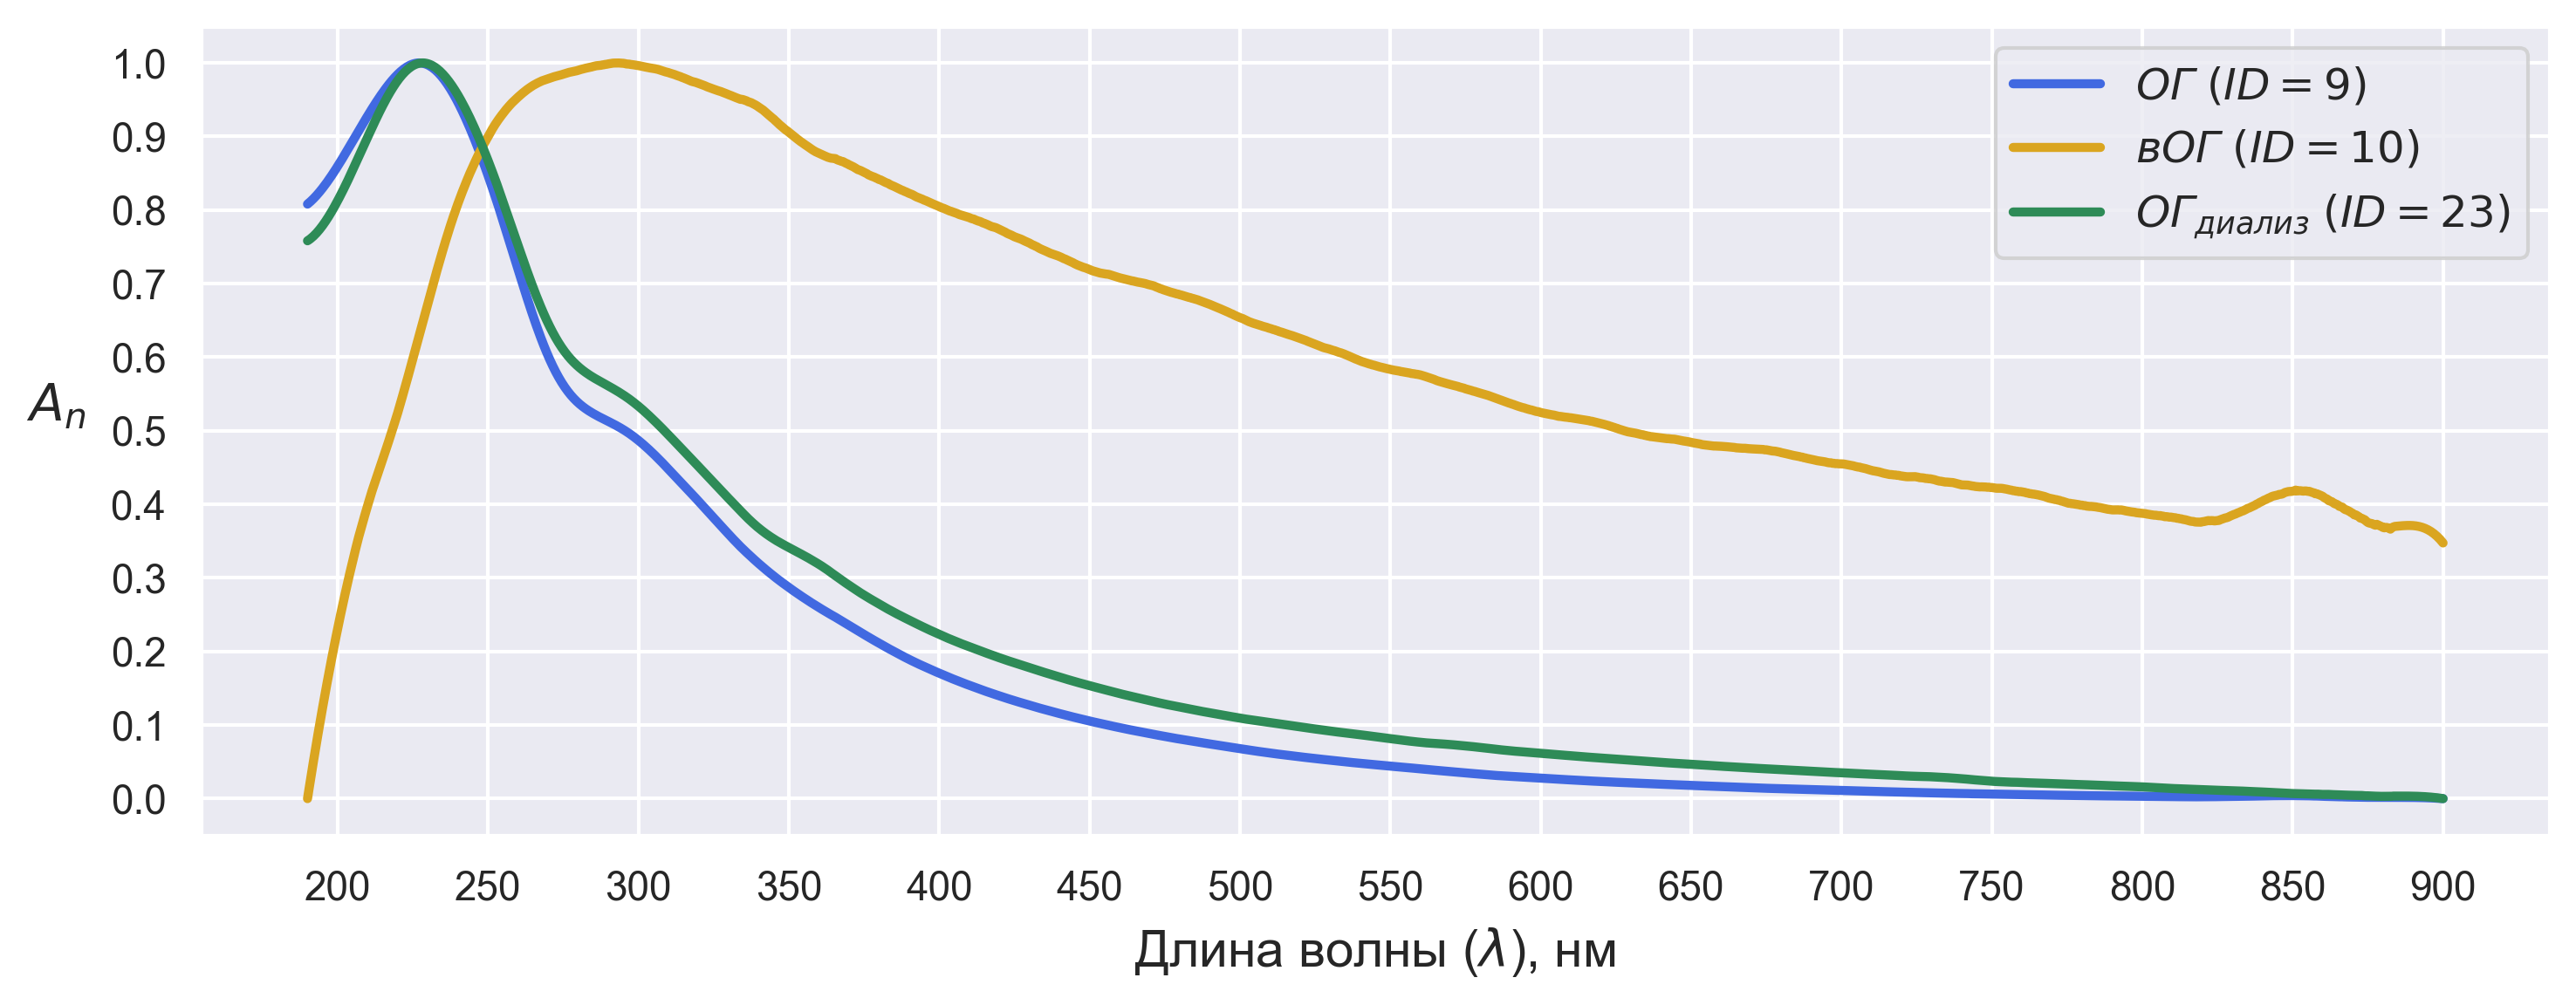

In [13]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(wavelength, go_spectrum, linewidth=2.5, color='RoyalBlue', label='$ОГ$ $(ID = 9)$')
ax.plot(wavelength, rgo_spectrum, linewidth=2.5, color='Goldenrod', label='$вОГ$ $(ID = 10)$')
ax.plot(wavelength, god_spectrum, linewidth=2.5, color='SeaGreen', label='$ОГ_{диализ}$ $(ID = 23)$')

ax.set_xlabel('Длина волны ($λ$), нм', fontsize=fontsize, labelpad=5)
ax.set_ylabel('$A_{n}$', fontsize=fontsize, labelpad=15, rotation=0)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax.legend(loc='best', fontsize=fontsize-2)

plt.tight_layout()

plt.savefig(f'{path_to_save}/principal_spectra_3_types.png', dpi=600)

plt.show()

## Long-wavelength scattering

### Principal *log-log* spectra of 3 *GO* types

In [14]:
log_wavelength = data_log.loc['wavelength']

go_log_spectrum = data_log.loc['9']
rgo_log_spectrum = data_log.loc['10']
god_log_spectrum = data_log.loc['23']

fontsize = 14

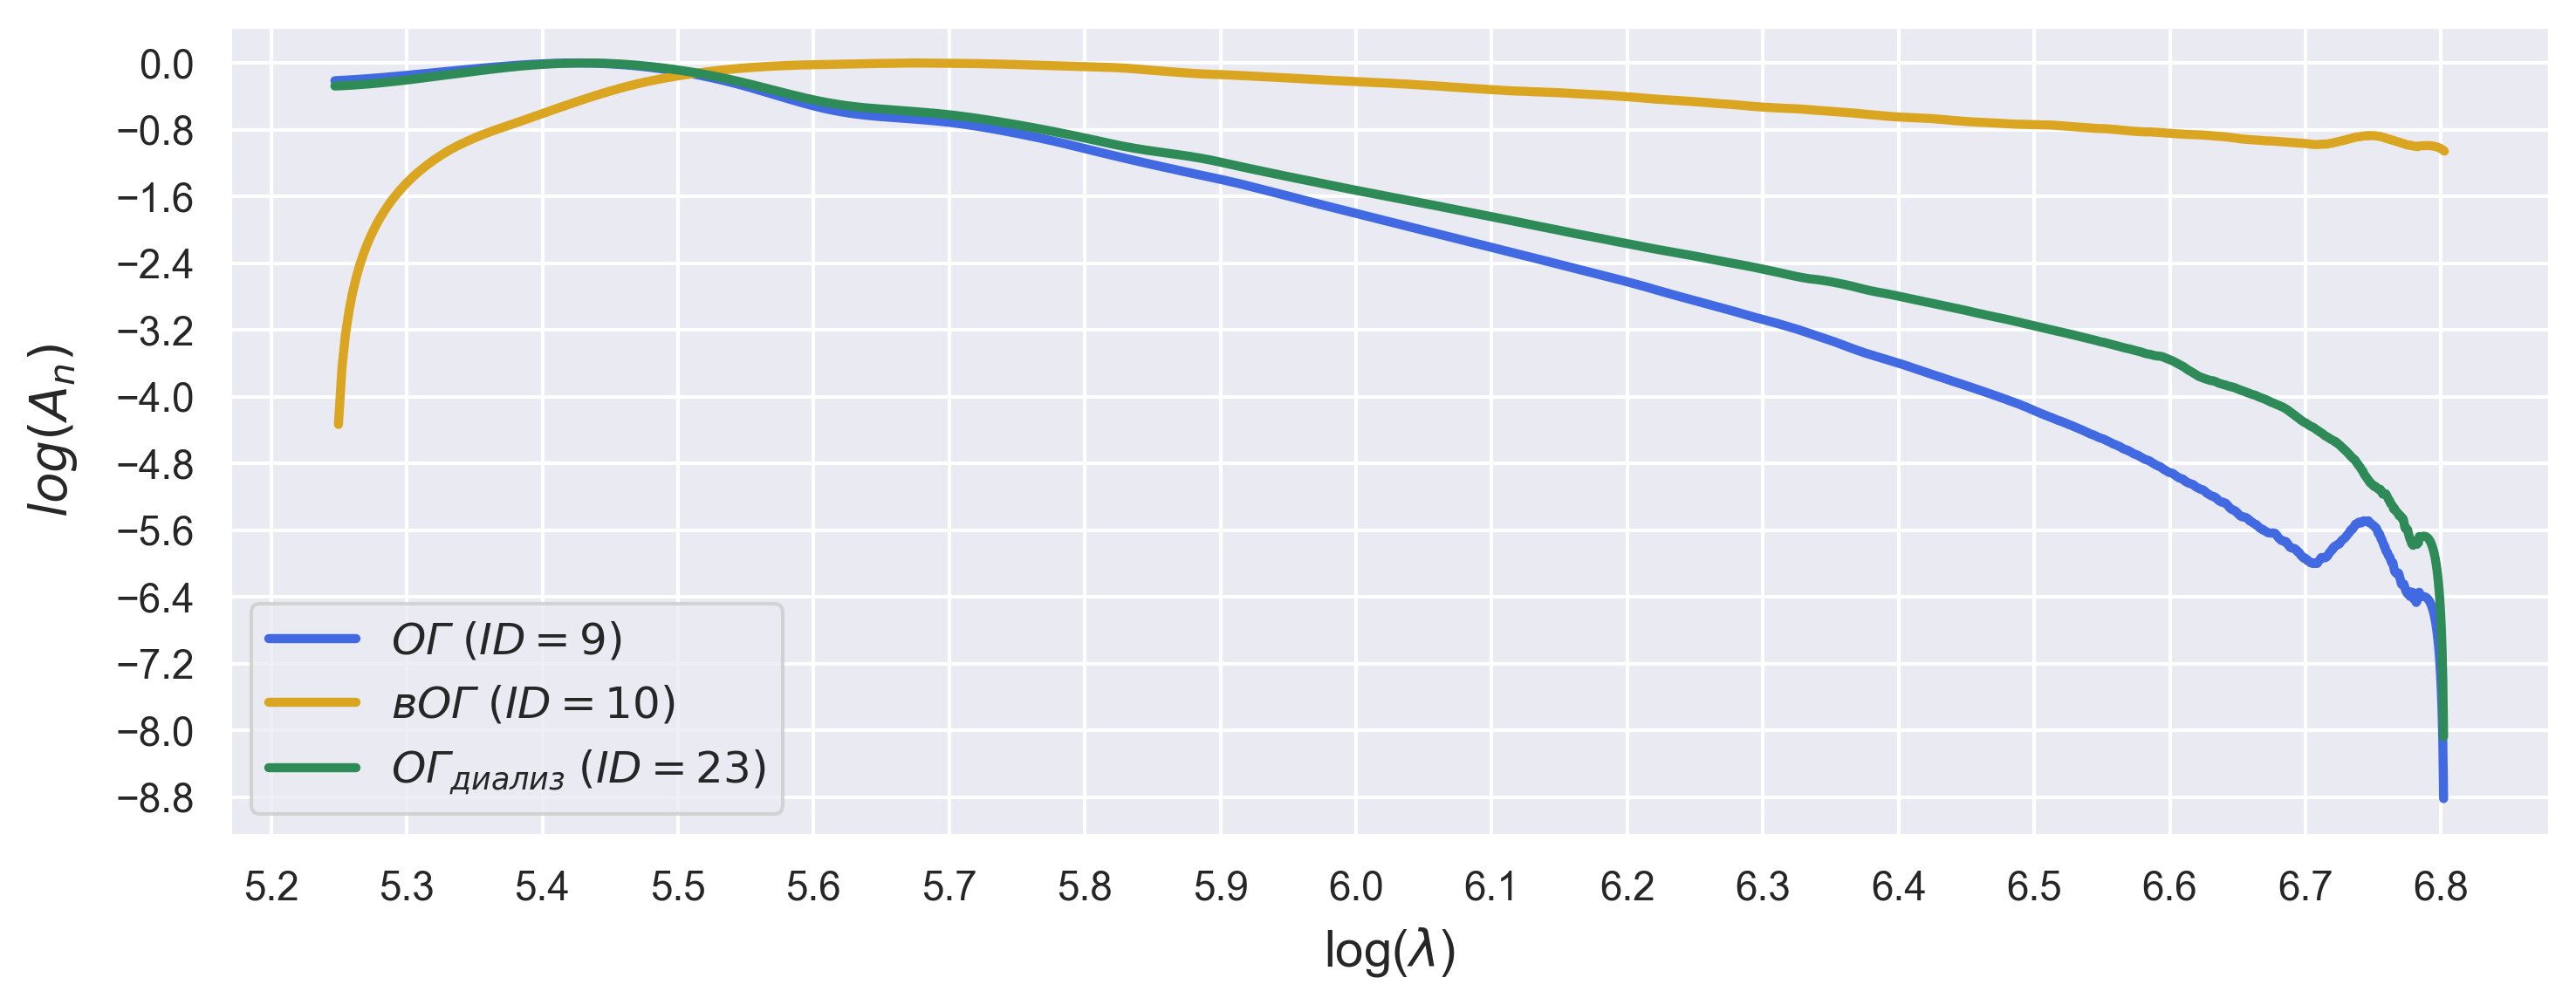

In [15]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(log_wavelength, go_log_spectrum, linewidth=2.5, color='RoyalBlue', label='$ОГ$ $(ID = 9)$')
ax.plot(log_wavelength, rgo_log_spectrum, linewidth=2.5, color='Goldenrod', label='$вОГ$ $(ID = 10)$')
ax.plot(log_wavelength, god_log_spectrum, linewidth=2.5, color='SeaGreen', label='$ОГ_{диализ}$ $(ID = 23)$')

ax.set_xlabel('log($λ$)', fontsize=fontsize, labelpad=5)
ax.set_ylabel('$log(A_{n})$', fontsize=fontsize, labelpad=10, rotation=90)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.8))

ax.legend(loc='best', fontsize=fontsize-2)

plt.tight_layout()

plt.savefig(f'{path_to_save}/principal_log_log_spectra_3_types_all_range.png', dpi=600)

plt.show()

### Principal *log-log* spectra of 3 *GO* types in selected range

In [16]:
log_wavelength = data_log_selected.loc['wavelength']

go_log_spectrum_selected = data_log_selected.loc['9']
rgo_log_spectrum_selected = data_log_selected.loc['10']
god_log_spectrum_selected = data_log_selected.loc['23']

fontsize = 14

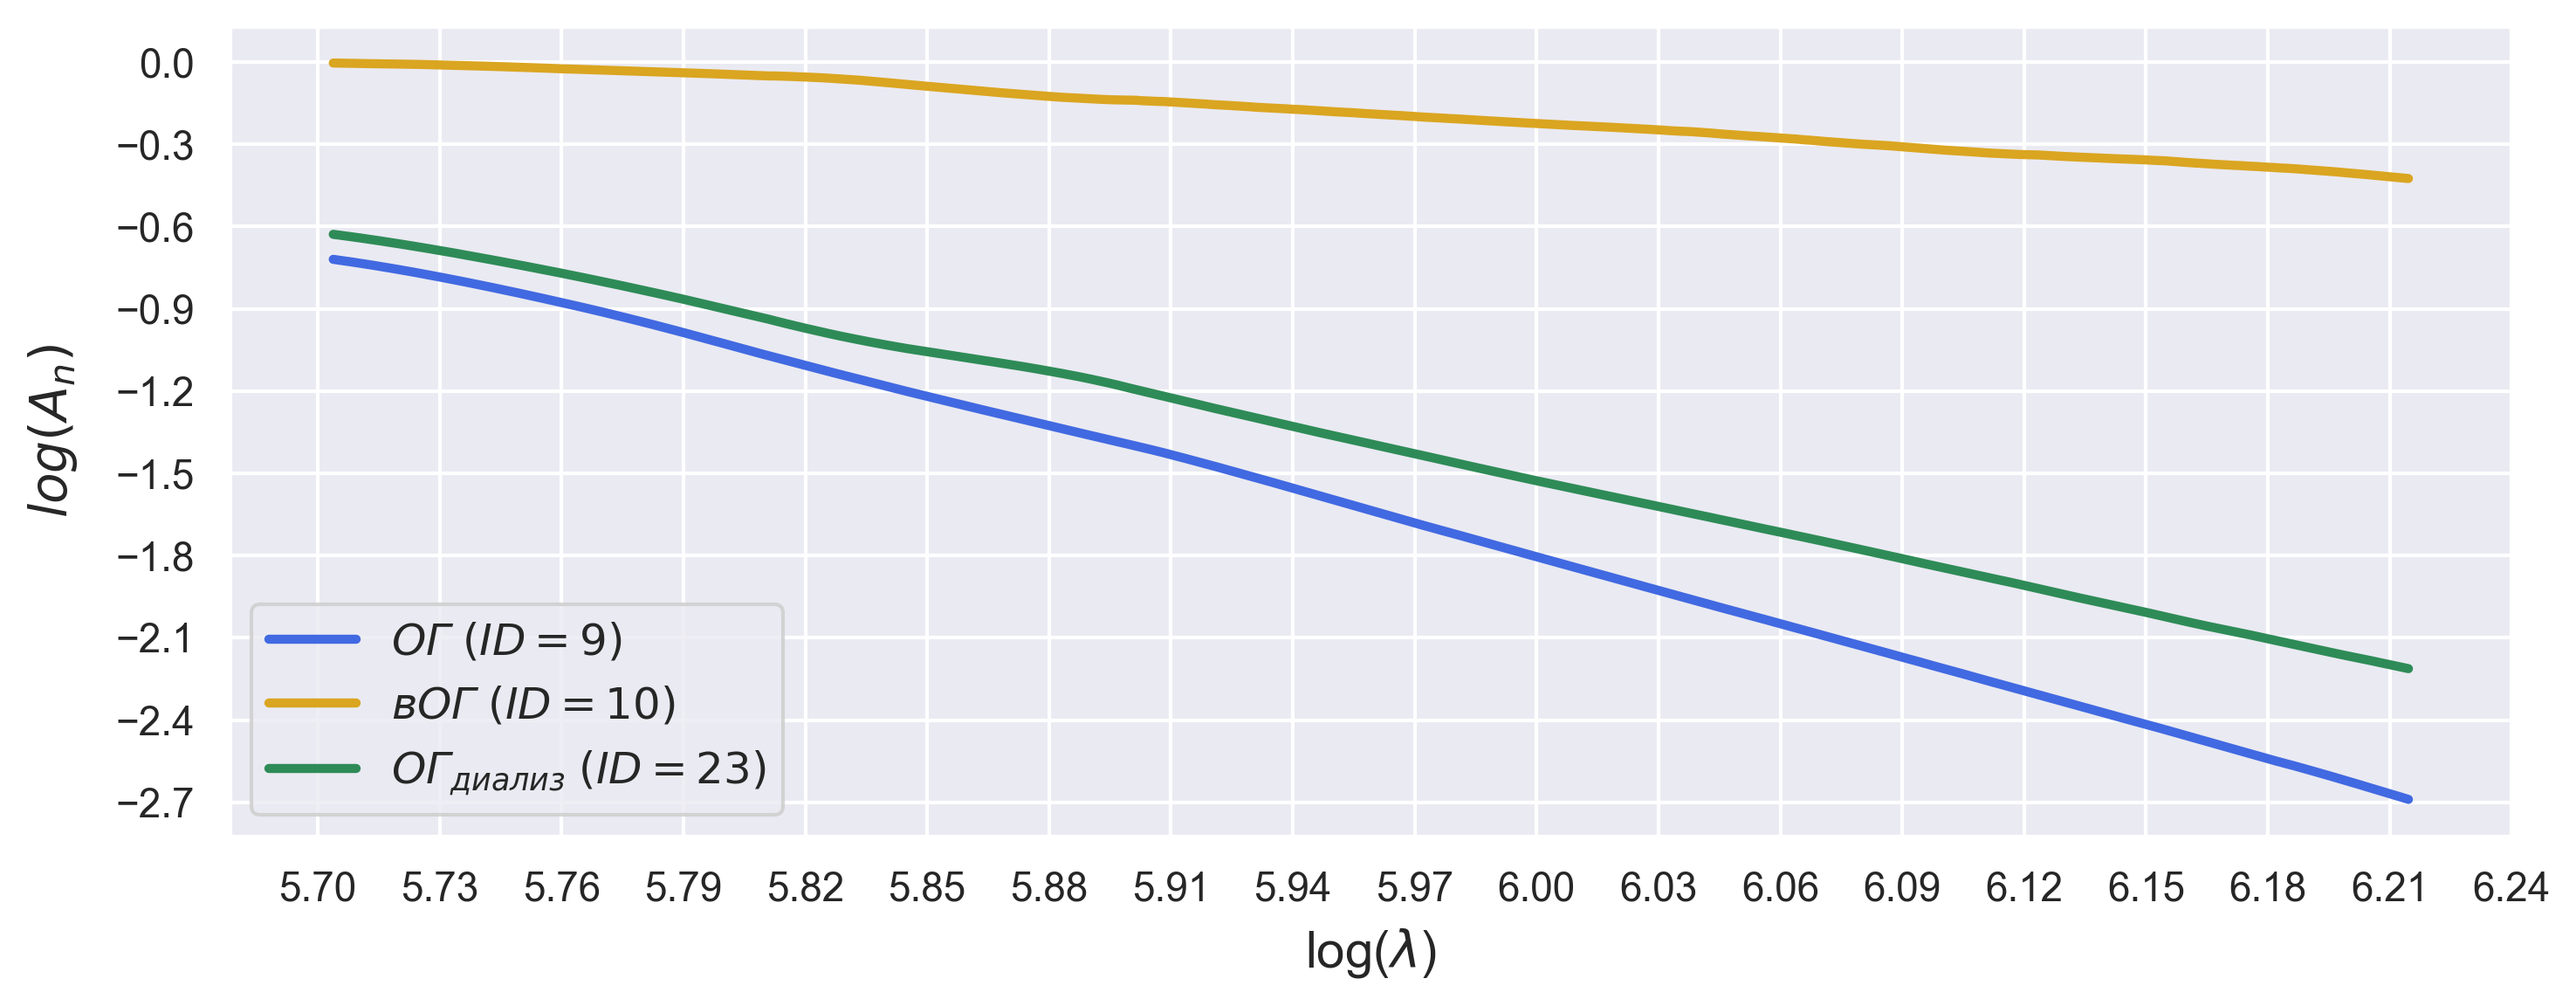

In [17]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(log_wavelength, go_log_spectrum_selected, linewidth=2.5, color='RoyalBlue', label='$ОГ$ $(ID = 9)$')
ax.plot(log_wavelength, rgo_log_spectrum_selected, linewidth=2.5, color='Goldenrod', label='$вОГ$ $(ID = 10)$')
ax.plot(log_wavelength, god_log_spectrum_selected, linewidth=2.5, color='SeaGreen', label='$ОГ_{диализ}$ $(ID = 23)$')

ax.set_xlabel('log($λ$)', fontsize=fontsize, labelpad=5)
ax.set_ylabel('$log(A_{n})$', fontsize=fontsize, labelpad=10, rotation=90)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.03))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))

ax.legend(loc='best', fontsize=fontsize-2)

plt.tight_layout()

plt.savefig(f'{path_to_save}/principal_log_log_spectra_3_types_selected_range.png', dpi=600)

plt.show()

### Tangent of the slope analysis of dependencies $log(A_{n}) = f(log(\lambda)$

#### Slope values calculation

In [18]:
x = data_log_selected.iloc[0].values.reshape(-1, 1)
idx_lst = data_log_selected.index[1:]

In [19]:
slopes_lst = []

for idx in idx_lst:
    y = data_log_selected.loc[idx].values
    
    model = LinearRegression()
    model.fit(x, y)

    slope =  model.coef_[0]
    slopes_lst.append(slope)

In [20]:
slopes_df = pd.DataFrame({
    'Index': idx_lst,
    "Slope": slopes_lst
})

slopes_df = slopes_df.set_index('Index')
slopes_df['Type'] = samples_description['Type'].tolist()

print(slopes_df.shape)
slopes_df.T

(25, 2)


Index,1,2,3,6,8,9,10,11,12,13,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Slope,-3.335403,-2.645148,-3.016748,-1.38317,-2.595082,-3.946011,-0.866641,-3.071444,-3.486946,-3.026757,-2.834369,-2.926215,-2.743009,-2.914267,-1.018963,-2.674488,-3.160139,-3.277652,-3.244652,-2.936678,-2.880072,-2.78086,-2.589158,-2.802278,-2.694849
Type,$ОГ$,$ОГ$,$ОГ$,$вОГ$,$ОГ$,$ОГ$,$вОГ$,$ОГ$,$ОГ$,$ОГ$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$вОГ$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$,$ОГ_{диализ}$


*Aggregates statistics by sample type*

In [21]:
slopes_df.groupby('Type').agg(['min', 'max', 'mean', 'median'])

Slope                              
                    min       max      mean    median
Type                                                 
$ОГ$          -3.946011 -2.595082 -3.140442 -3.049101
$ОГ_{диализ}$ -3.277652 -2.589158 -2.889906 -2.857220
$вОГ$         -1.383170 -0.866641 -1.089592 -1.018963

#### Slope values visualization

In [22]:
type_color_dict = {
    '$ОГ$': 'RoyalBlue',  # '$GO$': 'RoyalBlue',
    '$вОГ$': 'Goldenrod',  # '$rGO$': 'Goldenrod',
    '$ОГ_{диализ}$': 'SeaGreen'  # '$GO_{d}$': 'SeaGreen'
}

fontsize = 12

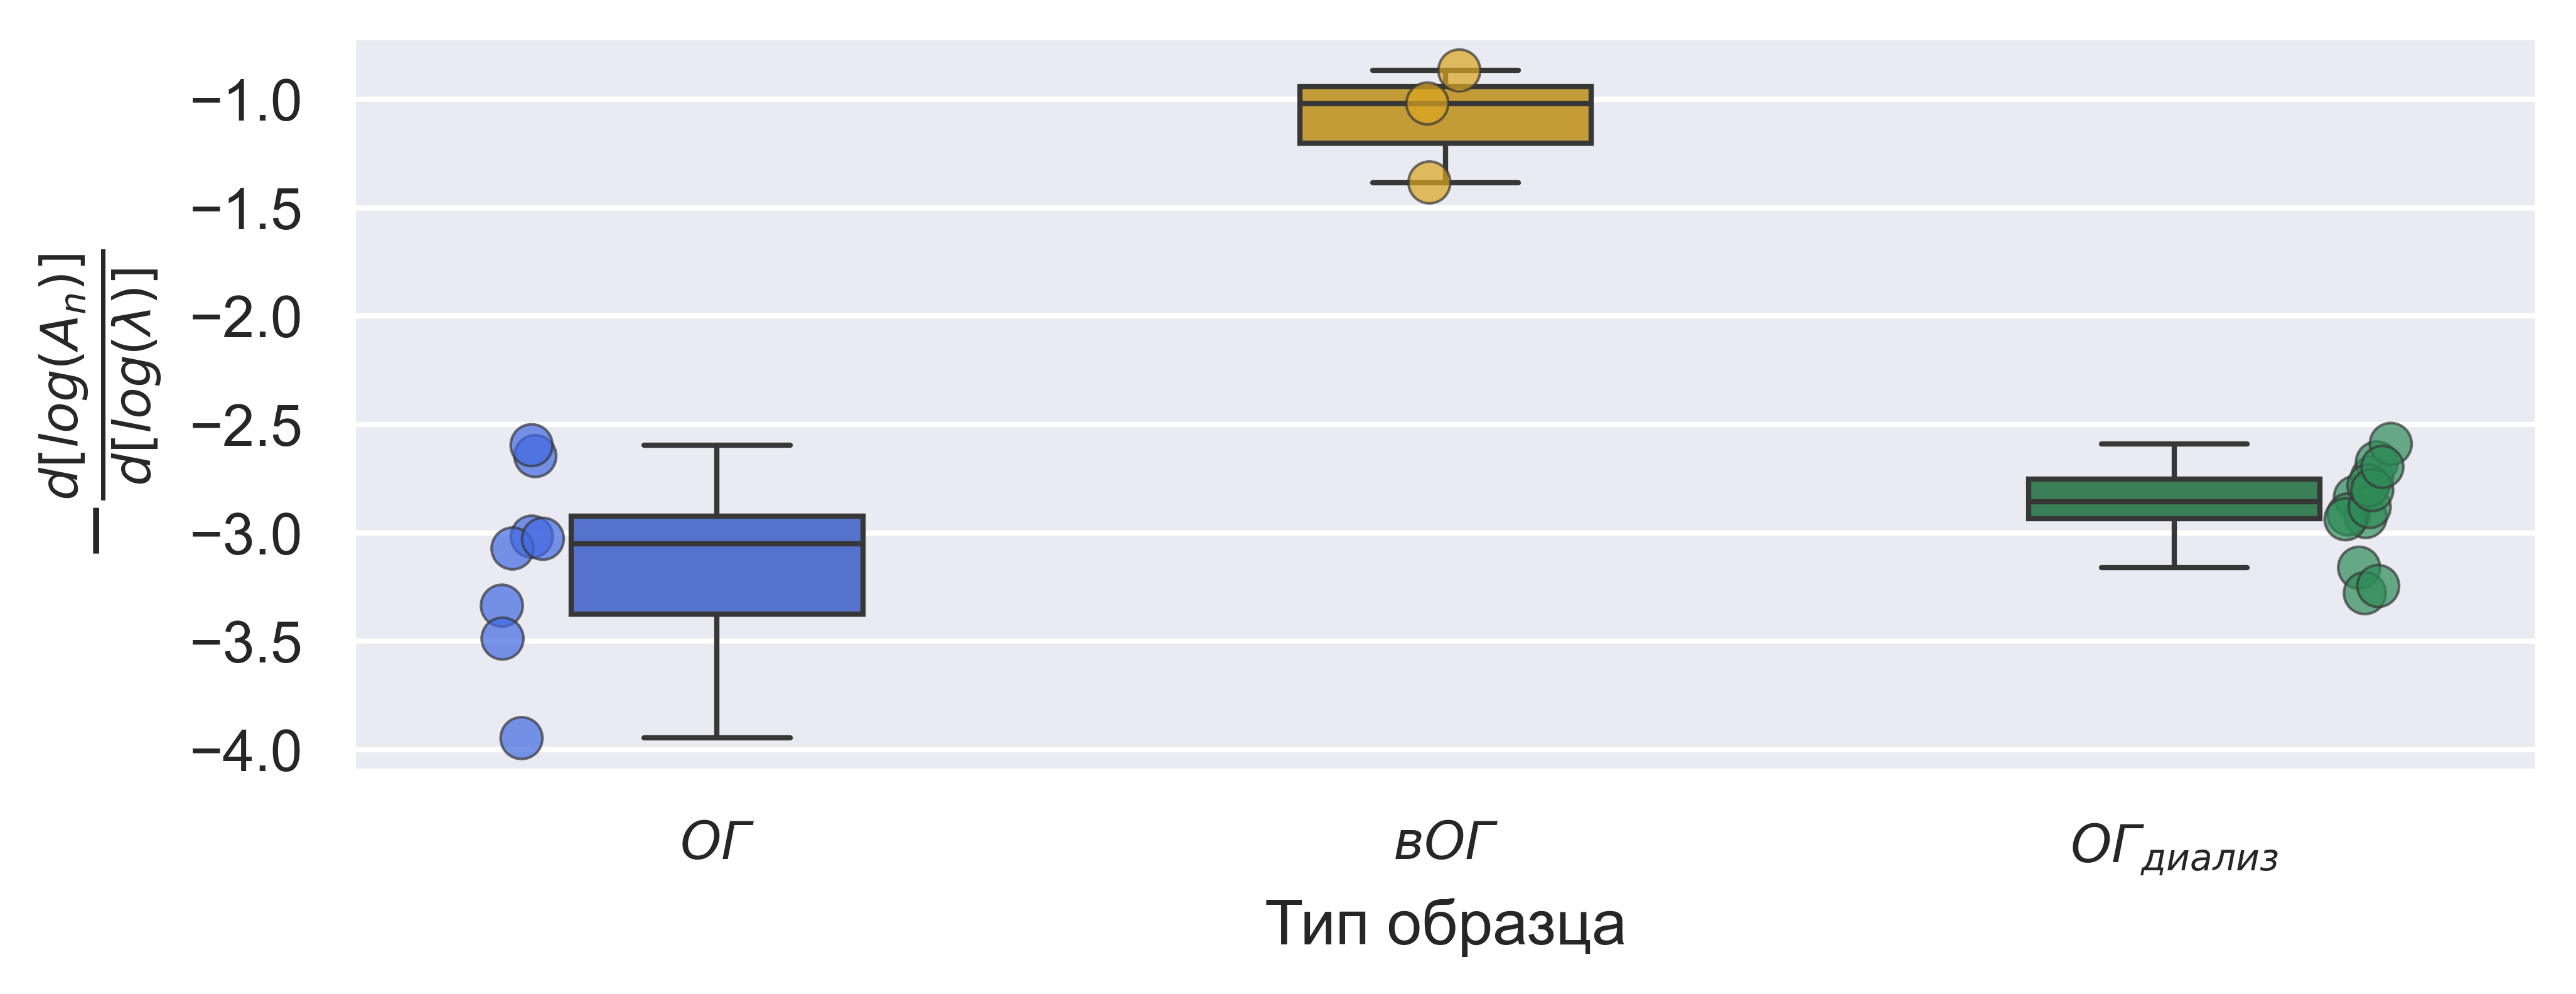

In [23]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(7, 2.8), dpi=600)

sns.boxplot(
    data=slopes_df,
    x='Type',
    y='Slope',
    palette=type_color_dict,
    width=0.4,
    showfliers=False,
    ax=ax
)

sns.stripplot(
    data=slopes_df,
    x='Type',
    y='Slope',
    hue='Type',
    palette=type_color_dict,
    alpha=0.7,
    size=8,
    linewidth=0.5,
    dodge=True,
    ax=ax
)

ax.set_ylabel(r'$-\frac{d[log(A_{n})]}{d[log(λ)]}$', fontsize=fontsize+2, rotation=90, labelpad=5)
ax.set_xlabel("Тип образца", fontsize=fontsize)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize-2)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

if ax.legend_:
    ax.legend_.remove()

plt.tight_layout()

plt.savefig(f'{path_to_save}/slope_boxplot_by_type.png', dpi=600)

plt.show()

## UV/Vis spectra derivatives & *PCA* results

In [24]:
fontsize = 16
fontstyle = 'normal'
linewidth = 3.0

markersize = 400
random_state = 42

n_components = 2

# type_color_dict = {
#     '$GO$': 'RoyalBlue',
#     '$rGO$': 'Goldenrod',
#     '$GO_{d}$': 'SeaGreen'
# }

type_color_dict = {
    '$ОГ$': 'RoyalBlue',
    '$вОГ$': 'Goldenrod',
    '$ОГ_{диализ}$': 'SeaGreen'
}

In [25]:
data_der = data.copy()

print(data_der.shape)
data_der.head(3)

(26, 1421)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
wavelength,900.000000,899.500000,899.000000,898.500000,8.980000e+02,897.500000,897.000000,896.500000,896.000000,895.500000,895.000000,894.500000,894.000000,893.500000,893.000000,892.500000,892.000000,891.500000,891.000000,890.500000,890.000000,889.500000,889.000000,888.500000,888.000000,...,202.000000,201.500000,201.000000,200.50000,200.000000,199.500000,199.000000,198.500000,198.000000,197.500000,197.000000,196.500000,196.000000,195.500000,195.000000,194.500000,194.000000,193.500000,193.000000,192.50000,192.000000,191.500000,191.000000,190.500000,190.000000
1,0.000028,0.000017,0.000009,0.000003,4.766199e-07,0.000000,0.000002,0.000006,0.000013,0.000021,0.000032,0.000044,0.000058,0.000074,0.000092,0.000111,0.000131,0.000153,0.000176,0.000200,0.000225,0.000251,0.000278,0.000306,0.000334,...,0.908611,0.906940,0.905411,0.90403,0.902806,0.901747,0.900858,0.900149,0.899625,0.899296,0.899168,0.899248,0.899545,0.900065,0.900816,0.901806,0.903042,0.904531,0.906281,0.90830,0.910594,0.913171,0.916039,0.919206,0.922678
2,0.000000,0.000337,0.000658,0.000963,1.252841e-03,0.001527,0.001787,0.002034,0.002266,0.002486,0.002694,0.002889,0.003073,0.003247,0.003410,0.003563,0.003707,0.003842,0.003969,0.004088,0.004200,0.004306,0.004405,0.004498,0.004586,...,0.977502,0.978137,0.978782,0.97944,0.980112,0.980801,0.981509,0.982239,0.982991,0.983769,0.984575,0.985411,0.986280,0.987182,0.988121,0.989099,0.990117,0.991179,0.992286,0.99344,0.994644,0.995900,0.997210,0.998576,1.000000


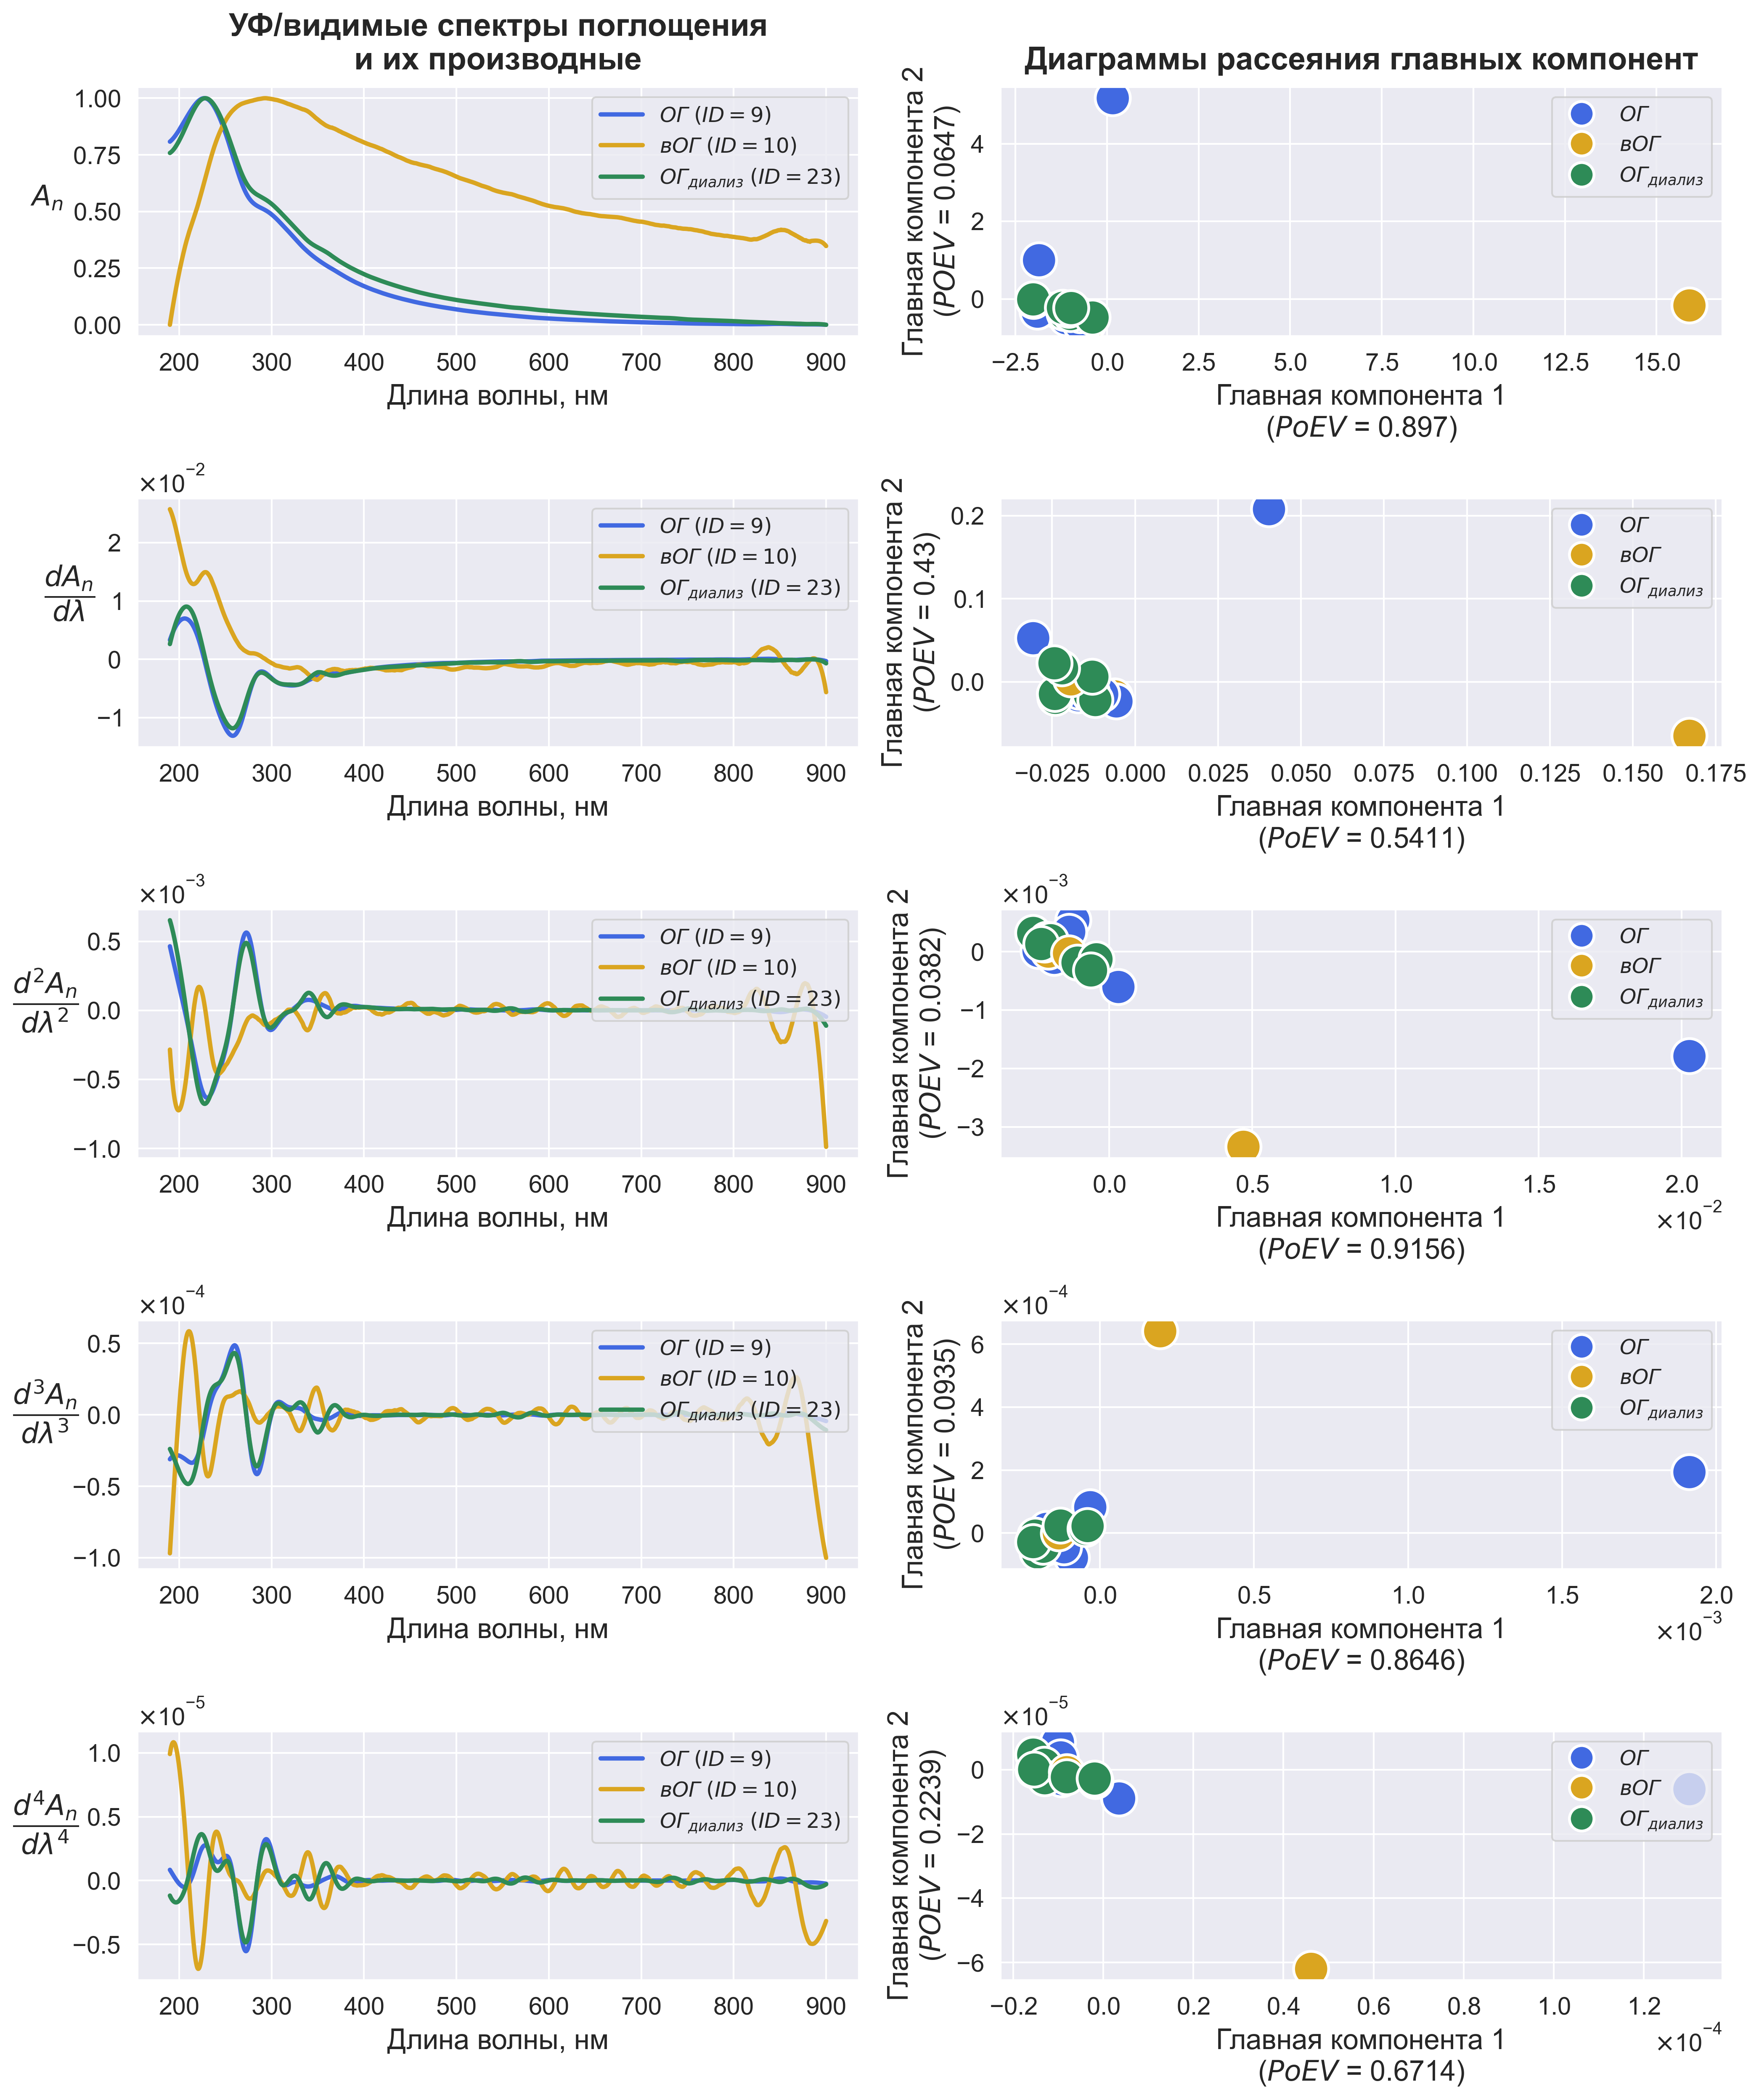

In [26]:
sns.set_theme()

nrows = 5
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 16.8), dpi=300)
axes = axes.flatten()

axes[0].set_title("УФ/видимые спектры поглощения\nи их производные", fontsize=fontsize+2, fontweight='bold', pad=10)
axes[1].set_title("Диаграммы рассеяния главных компонент", fontsize=fontsize+2, fontweight='bold', pad=10)

data_der = data.copy()

for i in range(5):
    wavelength = data_der.loc['wavelength']

    if i > 0:
        for idx in data_der.index[1:]:
            data_der.loc[idx] = savgol_filter(np.gradient(data_der.loc[idx], wavelength), window_length=63, polyorder=3)

    ax1 = axes[i * 2]
    ax2 = axes[i * 2 + 1]

    ax1.plot(wavelength, data_der.loc['9'], linewidth=2.5, color='RoyalBlue', label='$ОГ$ $(ID = 9)$')
    ax1.plot(wavelength, data_der.loc['10'], linewidth=2.5, color='Goldenrod', label='$вОГ$ $(ID = 10)$')
    ax1.plot(wavelength, data_der.loc['23'], linewidth=2.5, color='SeaGreen', label='$ОГ_{диализ}$ $(ID = 23)$')

    ylabel_map = {
        0: "$A_{n}$",
        1: r"$\dfrac{dA_n}{d\lambda}$"
    }
    ylabel = ylabel_map.get(i, rf"$\dfrac{{d^{i}A_n}}{{d\lambda^{i}}}$")

    ax1.set_ylabel(ylabel, fontstyle='italic', fontsize=fontsize, labelpad=15, rotation=0)
    ax1.set_xlabel('Длина волны, нм', fontstyle='normal', fontsize=fontsize, labelpad=5)  # Wavelength, nm; Длина волны, нм
    
    ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax1.yaxis.get_major_formatter().set_powerlimits((-2, 2))
    ax1.yaxis.get_offset_text().set_fontsize(fontsize-2)

    ax1.tick_params(axis='both', labelsize=fontsize-2)

    ax1.legend(loc='upper right', fontsize=fontsize-4)

    spectral_data = data_der.iloc[1:, :]
    pca = PCA(n_components=2, random_state=42)
    spectral_data_pca = pd.DataFrame(pca.fit_transform(spectral_data), columns=['PC_1', 'PC_2'])
    explained_variance = [round(k, 4) for k in pca.explained_variance_ratio_]

    spectral_data_pca = pd.concat([spectral_data_pca, samples_description['Type']], axis=1)

    sns.scatterplot(data=spectral_data_pca, x='PC_1', y='PC_2', hue='Type', palette=type_color_dict, s=400, ax=ax2)

    ax2.set_xlabel(f'Главная компонента 1\n($PoEV$ = {explained_variance[0]})', fontstyle='normal', fontsize=fontsize, labelpad=5)
    ax2.set_ylabel(f'Главная компонента 2\n($POEV$ = {explained_variance[1]})', fontstyle='normal', fontsize=fontsize, labelpad=5)

    for axis in [ax2.xaxis, ax2.yaxis]:
        axis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        axis.get_major_formatter().set_powerlimits((-2, 2))  
        axis.offsetText.set_fontsize(fontsize-2)

    ax2.tick_params(axis='both', labelsize=fontsize-2)

    ax2.legend(loc='upper right', markerscale=0.7, fontsize=fontsize-4)

# plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.tight_layout()

plt.savefig(f'{path_to_save}/combined_spectra_pca.png', dpi=600)

plt.show()

# Additional information

## 3D-visualization of spectra

In [27]:
# wavelength = data.loc['wavelength']

# indexes = samples_description.index
# types = samples_description['Type']

# sample_id_type_dict = {f'{index}': type for index, type in zip(indexes, types)}

In [28]:
# type_color_dict = {
#     '$GO$': 'RoyalBlue',
#     '$rGO$': 'Goldenrod',
#     '$GO_{d}$': 'SeaGreen'
# }

# fontsize = 18

In [29]:
# sns.set_theme()

# fig = plt.figure(figsize=(16, 16), dpi=300)
# ax = fig.add_subplot(projection='3d')

# wavelength = pd.to_numeric(data.loc['wavelength'], errors='coerce')

# legend_labels = {}

# for index in data.index[1:]:
#     sample_type = sample_id_type_dict[index]
#     color = type_color_dict[sample_type]

#     z = pd.to_numeric(data.loc[index], errors='coerce')
#     x = wavelength
#     y = np.full_like(wavelength, index, dtype=float)
    
#     ax.plot(x, y, z, color=color, label=sample_type, linewidth=2.0)
    
#     if sample_type not in legend_labels:
#         legend_labels[sample_type] = plt.Line2D([0], [0], color=color, lw=2)

# ax.set_xlabel('Wavelength, nm', fontstyle='normal', fontsize=fontsize, labelpad=10)
# ax.set_ylabel('Sample ID', fontstyle='normal', fontsize=fontsize, labelpad=10)
# ax.set_zlabel('Normalized absorbace', fontstyle='normal', rotation=90, fontsize=fontsize, labelpad=5)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
# ax.zaxis.set_major_locator(ticker.MultipleLocator(0.1))

# ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize-4)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize-4)
# ax.set_zticklabels(ax.get_zticklabels(), fontsize=fontsize-4)

# ax.legend(legend_labels.values(), legend_labels.keys(), loc='center right', fontsize=fontsize-2)

# ax.view_init(elev=15, azim=30)
# ax.dist = 0
# ax.grid(True)

# plt.tight_layout()

# plt.savefig(f'{path_to_save}/3d_visualization_spectra.png', dpi=600)

# plt.show()